In [1]:
import data_utils.data_analysis as data_analysis

from sklearn.model_selection import train_test_split

import models.rf as rf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#READ THE DATASET
filename='datasets/galadriel_dataset_24_03_14.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [3]:
#Get the clean shots
minval=8000
df_input_clean,df_time_clean,df_freq_int_clean=data_analysis.clean_shots_below(minval,
    df_input,df_time,df_freq_int)


Shots with max val below this will be discarded: 8000



In [4]:
#Calculate the variance
dup_shots=2
df_time_clean_var=data_analysis.get_var(df_input_clean,df_time_clean,dup_shots)
df_time_clean_var_sum=df_time_clean_var.sum(axis=1)

### Define inputs and targets

In [5]:
X=df_input_clean[['order2','order3','order4']]
y=df_time_clean
var=df_time_clean_var

#split into train and test set
X_train, X_test, y_train, y_test,var_train, var_test = train_test_split(X, y,var, test_size=0.3, random_state=101)

#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)
var_test_reset=var_test.reset_index(drop=True)

### Train the forward model

In [6]:
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

rf_model_forward=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state)
y_predict_forest_forward=rf.make_rf_prediction(rf_model_forward,X_test)

### Train Backward model

In [7]:
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

rf_model_backward=rf.fit_random_forest(y_train,X_train,n_estimators, max_features,max_depth, random_state)
X_predict_forest_backward=rf.make_rf_prediction(rf_model_backward,y_test)

### Roundtrip prediction

In [8]:
y_predict_roundtrip=rf_model_forward.predict(X_predict_forest_backward)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Error distribution

In [9]:
def error_dist_mae(y_prediction,y_test):
    df_aux=abs(y_test-y_prediction)
    df_error=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    #print(df_error)

    print('ID max error:',df_error.idxmax())
    print('Max error:',df_error.max())
    return df_error

In [10]:
def error_dist_mse(y_prediction,y_test):
    df_aux=abs(y_test-y_prediction)**2
    df_error=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    #print(df_error)

    print('ID max error:',df_error.idxmax())
    print('Max error:',df_error.max())
    return df_error

In [11]:
def error_dist_var(y_prediction,y_test,var_test):
    df_aux=(abs(y_test-y_prediction)**2)/var_test
    df_error=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    var_test_inv=var_test.apply(lambda x: 1/x)
    var_test_inv.replace([np.inf, -np.inf], 1, inplace=True)
    print(var_test_inv)
    print((var_test_inv).sum(axis=1))
    df_error=df_error/((var_test_inv).sum(axis=1))
    df_error.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(df_error)
    #print(var_test)

    print('ID max error:',df_error.idxmax())
    print('Max error:',df_error.max())
    return df_error

In [12]:
df_error_mae=error_dist_mae(y_predict_roundtrip,y_test_reset)
df_error_mse=error_dist_mse(y_predict_roundtrip,y_test_reset)
df_error_var=error_dist_var(y_predict_roundtrip,y_test_reset,var_test_reset)

ID max error: 1228
Max error: 0.12746206877206911
ID max error: 3413
Max error: 0.036799609212184003
                0             1             2             3             4   \
0     1.896803e+06  2.182602e+06  1.939549e+05  7.496688e+03  4.801138e+03   
1     3.307250e+05  2.907583e+06  4.709384e+04  9.407130e+03  8.434965e+03   
2     2.235524e+07  1.248400e+08  2.330866e+08  2.755561e+05  5.446549e+05   
3     9.868399e+06  1.346100e+07  3.417399e+06  8.791787e+04  9.030289e+04   
4     6.947554e+07  2.956461e+07  5.148954e+06  3.898259e+05  8.419751e+05   
...            ...           ...           ...           ...           ...   
3640  5.018401e+08  1.041667e+10  1.588590e+08  1.319674e+06  3.683947e+06   
3641  2.606244e+06  1.246548e+07  2.431408e+05  1.419483e+05  1.024938e+05   
3642  4.888488e+07  8.589425e+08  5.921684e+06  9.464401e+05  6.016504e+05   
3643  2.308047e+08  5.559461e+06  4.889049e+05  8.997907e+05  2.217085e+06   
3644  4.914434e+07  2.980744e+07  1.44807

In [13]:
1/3.439e-07

2907822.041291073

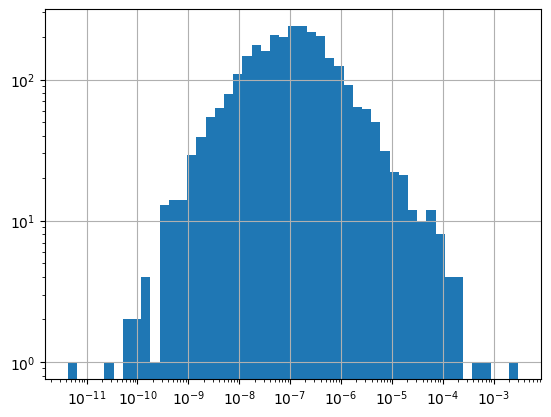

In [14]:
fig, ax = plt.subplots()
logbins = np.geomspace(df_error_var.min(), df_error_var.max(), 50)
#df_error_var.hist(bins=500)
df_error_var.hist(bins=logbins)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_xlim(0,0.0005)

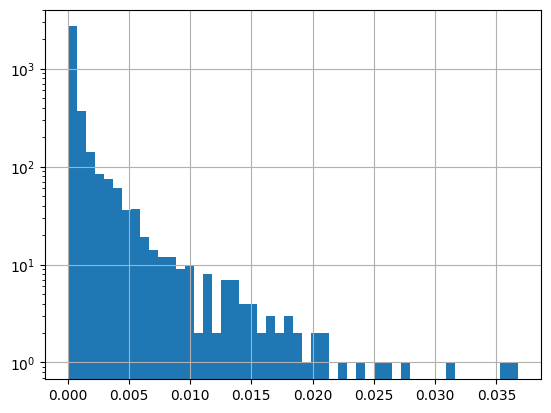

In [15]:
fig, ax = plt.subplots()
df_error_mse.hist(bins=50)
ax.set_yscale('log')
#ax.set_xscale('log')

# ERROR DISTRIBUTION IN THE PARAMETER SPACE

In [16]:
def plot_error_param_space(X_test,df_error):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X_test['order2'], X_test['order3'], df_error,c=df_error,cmap='jet')
    ax.set_xlabel('order2')
    ax.set_ylabel('order3')
    ax.set_zlabel('Error')
    #zticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    #ax.set_zticks(np.log10(zticks))
    #print(df_error)
    #ax.set_zscale('log')
    ax.view_init(elev=20., azim=110)
    plt.title('Error vs order2 and order3')
    plt.show()

    fig = plt.figure()
    ax2 = fig.add_subplot(projection='3d')
    ax2.scatter(X_test['order3'], X_test['order4'], df_error,c=df_error,cmap='jet')
    ax2.set_xlabel('order3')
    ax2.set_ylabel('order4')
    ax2.set_zlabel('Error')
    #ax2.set_zscale('log')
    ax2.view_init(elev=20., azim=150)
    plt.title('error vs order3 and order4')
    plt.show()

    fig = plt.figure()
    ax3 = fig.add_subplot(projection='3d')
    ax3.scatter(X_test['order2'], X_test['order4'], df_error,c=df_error,cmap='jet')
    ax3.set_xlabel('order2')
    ax3.set_ylabel('order4')
    ax3.set_zlabel('Error')
    #ax3.set_zscale('log')
    ax3.view_init(elev=20., azim=150)
    plt.title('error vs order2 and order4')
    plt.show()
    return

### MEAN ABSOLUTE ERROR

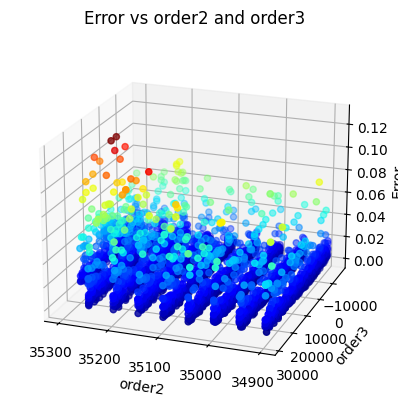

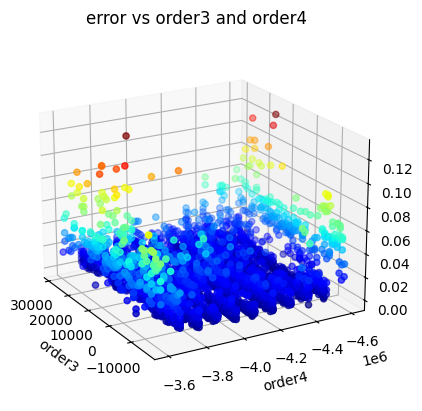

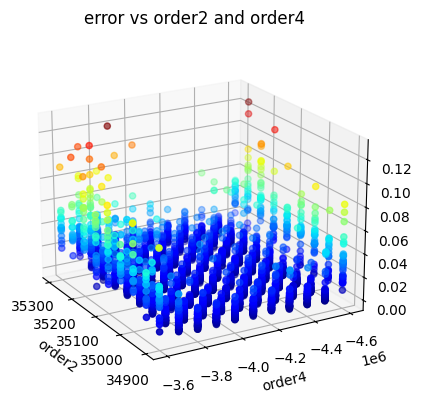

In [17]:
plot_error_param_space(X_test,df_error_mae)

### MEAN SQUARED ERROR

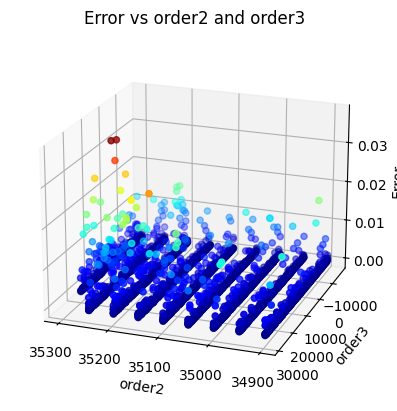

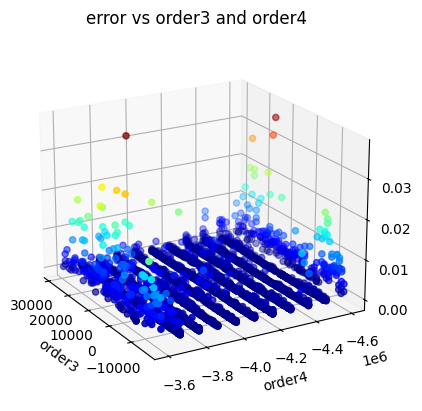

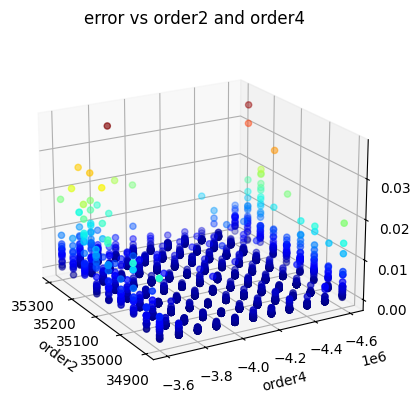

In [18]:
plot_error_param_space(X_test,df_error_mse)

### MEAN SQUARED ERRROR (WEIGTHED)

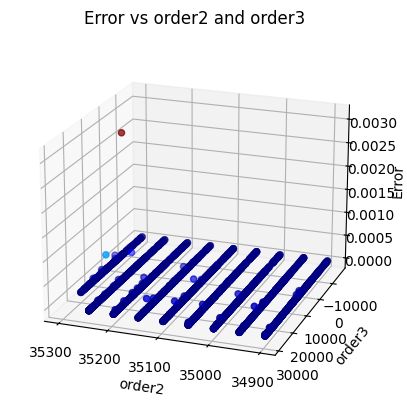

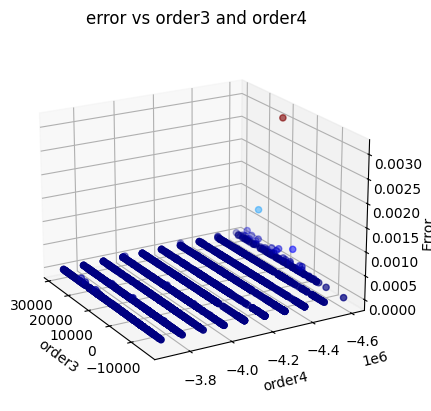

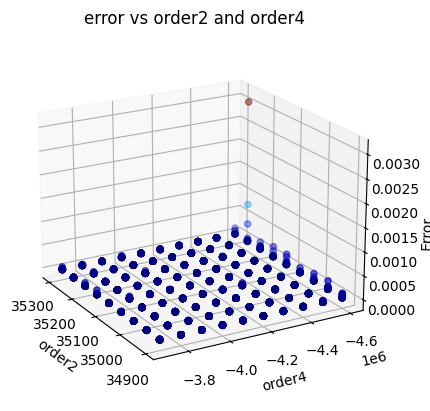

In [19]:
plot_error_param_space(X_test,df_error_var)

# Compare different datasets

In [20]:
#READ THE DATASET 24_03_14
filename='datasets/galadriel_dataset_24_03_14.h5'
df_input_240314,df_time_val_240314,df_time_240314,df_freq_val_240314,df_freq_int_240314 = data_analysis.read_dataset(filename)

#READ THE DATASET 24_04_11
filename='datasets/galadriel_dataset_24_04_11.h5'
df_input_240411,df_time_val_240411,df_time_240411,df_freq_val_240411,df_freq_int_240411 = data_analysis.read_dataset(filename)

#READ THE DATASET 24_05_09
filename='datasets/galadriel_dataset_24_05_09.h5'
df_input_240509,df_time_val_240509,df_time_240509,df_freq_val_240509,df_freq_int_240509 = data_analysis.read_dataset(filename)

#READ THE DATASET 24_06_06
filename='datasets/galadriel_dataset_24_06_06.h5'
df_input_240606,df_time_val_240606,df_time_240606,df_freq_val_240606,df_freq_int_240606 = data_analysis.read_dataset(filename)


Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [21]:
#Get the clean shots
minval=8000
df_input_clean_240314,df_time_clean_240314,df_freq_int_clean_240314=data_analysis.clean_shots_below(minval,
    df_input_240314,df_time_240314,df_freq_int_240314)

value=65000
df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411 = data_analysis.clean_shots_above(value,df_input_240411,df_time_240411,df_freq_int_240411)

#240519 and 240606 don't need to drop shots


Shots with max val below this will be discarded: 8000


Shots with max val above this will be discarded: 65000



In [22]:
dup_shots=2
#240314
df_time_clean_var_240314=data_analysis.get_var(df_input_clean_240314,df_time_clean_240314,dup_shots)
df_time_clean_var_sum_240314=df_time_clean_var_240314.sum(axis=1)

#240411
df_time_clean_var_240411=data_analysis.get_var(df_input_clean_240411,df_time_clean_240411,dup_shots)
df_time_clean_var_sum_240411=df_time_clean_var_240411.sum(axis=1)

#240509
df_time_clean_var_240509=data_analysis.get_var(df_input_240509,df_time_240509,dup_shots)
df_time_clean_var_sum_240509=df_time_clean_var_240509.sum(axis=1)

#240606
df_time_clean_var_240606=data_analysis.get_var(df_input_240606,df_time_240606,dup_shots)
df_time_clean_var_sum_240606=df_time_clean_var_240606.sum(axis=1)

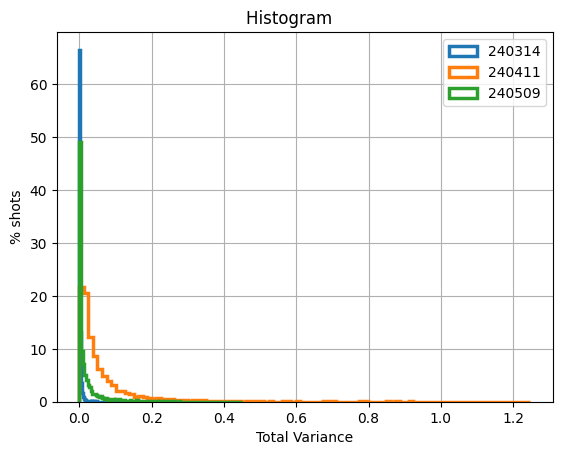

In [23]:
weights_time_240314 = 100*np.ones_like(df_time_clean_var_sum_240314) / len(df_time_clean_var_sum_240314)
weights_time_240411 = 100*np.ones_like(df_time_clean_var_sum_240411) / len(df_time_clean_var_sum_240411)
weights_time_240509 = 100*np.ones_like(df_time_clean_var_sum_240509) / len(df_time_clean_var_sum_240509)
weights_time_240606 = 100*np.ones_like(df_time_clean_var_sum_240606) / len(df_time_clean_var_sum_240606)

df_time_clean_var_sum_240314.hist(bins=100,weights=weights_time_240314,histtype="step",linewidth=2.5,label='240314')
df_time_clean_var_sum_240411.hist(bins=100,weights=weights_time_240411,histtype="step",linewidth=2.5,label='240411')
df_time_clean_var_sum_240509.hist(bins=100,weights=weights_time_240509,histtype="step",linewidth=2.5,label='240509')
#df_time_clean_var_sum_240606.hist(bins=100,weights=weights_time_240606,histtype="step",linewidth=2.5,label='240606')


plt.ylabel('% shots')
plt.xlabel('Total Variance')
#plt.xlim(0,0.05)
plt.title('Histogram      ')#(total num. shots='+str(len(df_time_clean_var_sum_240314))+')')
plt.legend()

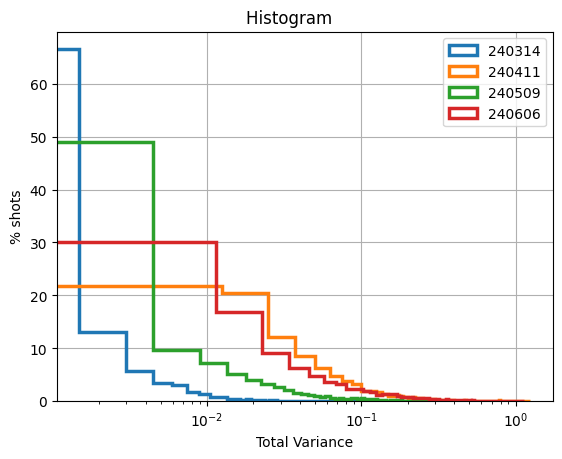

In [24]:
weights_time_240314 = 100*np.ones_like(df_time_clean_var_sum_240314) / len(df_time_clean_var_sum_240314)
weights_time_240411 = 100*np.ones_like(df_time_clean_var_sum_240411) / len(df_time_clean_var_sum_240411)
weights_time_240509 = 100*np.ones_like(df_time_clean_var_sum_240509) / len(df_time_clean_var_sum_240509)
weights_time_240606 = 100*np.ones_like(df_time_clean_var_sum_240606) / len(df_time_clean_var_sum_240606)

df_time_clean_var_sum_240314.hist(bins=100,weights=weights_time_240314,histtype="step",linewidth=2.5,label='240314')
df_time_clean_var_sum_240411.hist(bins=100,weights=weights_time_240411,histtype="step",linewidth=2.5,label='240411')
df_time_clean_var_sum_240509.hist(bins=100,weights=weights_time_240509,histtype="step",linewidth=2.5,label='240509')
df_time_clean_var_sum_240606.hist(bins=100,weights=weights_time_240606,histtype="step",linewidth=2.5,label='240606')


plt.ylabel('% shots')
plt.xlabel('Total Variance')
plt.xscale('log')
plt.title('Histogram      ')#(total num. shots='+str(len(df_time_clean_var_sum_240314))+')')
plt.legend()

# Dropping shots with high variance to improve model

In [25]:
#Drop the shots with a variance higher than some value
# Needs 'dup_shots' as the number of duplicate shots-1
# Also returns the variance dataframe
def clean_shots_high_var(value,dup_shots,df_input,df_time,df_freq_int):
    #maxval_freq=df_freq_int.max(axis=1)
    #meanval=maxval_freq.mean()
    #twosigma=2*maxval_freq.std()
    print('')
    print('Shots with variance above this will be discarded:',value)
    print('')

    #calculate the variance
    df_time_var=data_analysis.get_var(df_input,df_time,dup_shots)
    df_time_var_sum=df_time_var.sum(axis=1)

    #get the indexes of the shots that don't fulfilll the requirement
    badpoints=df_time_var_sum.index[(df_time_var_sum>value)].tolist()

    #print(badpoints)
    print('Number of dropped shots:{}'.format(len(badpoints)))
    print('which are a {:2.2f}% of the total number'.format(100*len(badpoints)/len(df_time_var_sum)))

    #Drop those shots from the databases
    df_input_clean=df_input.drop(badpoints)
    df_time_clean=df_time.drop(badpoints)
    df_freq_int_clean=df_freq_int.drop(badpoints)
    df_time_var_clean=df_time_var.drop(badpoints)

    #reset their indexes
    df_input_clean.reset_index(inplace=True,drop=True) #to start again from 0 (as the other DataFrames)
    df_time_clean.reset_index(inplace=True,drop=True)
    df_freq_int_clean.reset_index(inplace=True,drop=True)
    df_time_var_clean.reset_index(inplace=True,drop=True)

    #TESTING
    #print('Testing!')
    #print(df_freq_int_clean)
    #test the histogram
    #test_maxval_freq=df_freq_int_clean.max(axis=1)
    #test_maxval_freq.hist(bins=50)
    
    return df_input_clean,df_time_clean,df_freq_int_clean,df_time_var_clean


In [27]:
#READ THE DATASET
#240314
filename='datasets/galadriel_dataset_24_03_14.h5'
df_input_240314,df_time_val_240314,df_time_240314,df_freq_val_240314,df_freq_int_240314 = data_analysis.read_dataset(filename)
#240411
filename='datasets/galadriel_dataset_24_04_11.h5'
df_input_240411,df_time_val_240411,df_time_240411,df_freq_val_240411,df_freq_int_240411 = data_analysis.read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [28]:
#Get the clean shots
minval=8000
df_input_clean_240314,df_time_clean_240314,df_freq_int_clean_240314=data_analysis.clean_shots_below(minval,
    df_input_240314,df_time_240314,df_freq_int_240314)
#240411
minval=8000
maxval=65000
df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411=data_analysis.clean_shots_below(minval,
    df_input_240411,df_time_240411,df_freq_int_240411)
df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411=data_analysis.clean_shots_above(maxval,
    df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411)
#drop also the maxval for the *not* clean
df_input_240411,df_time_240411,df_freq_int_240411=data_analysis.clean_shots_above(maxval,
    df_input_240411,df_time_240411,df_freq_int_240411)


Shots with max val below this will be discarded: 8000


Shots with max val below this will be discarded: 8000


Shots with max val above this will be discarded: 65000


Shots with max val above this will be discarded: 65000



In [29]:
dup_shots=2
maxvar=0.05
#240314
df_input_clean_240314,df_time_clean_240314,df_freq_int_clean_240314,df_time_var_clean_240314=clean_shots_high_var(
    maxvar,dup_shots,df_input_clean_240314,df_time_clean_240314,df_freq_int_clean_240314)
df_time_var_clean_sum_240314=df_time_var_clean_240314.sum(axis=1)
#240411
df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411,df_time_var_clean_240411=clean_shots_high_var(
    maxvar,dup_shots,df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411)
df_time_var_clean_sum_240411=df_time_var_clean_240411.sum(axis=1)


Shots with variance above this will be discarded: 0.05

Number of dropped shots:40
which are a 0.33% of the total number

Shots with variance above this will be discarded: 0.05

Number of dropped shots:5616
which are a 36.95% of the total number


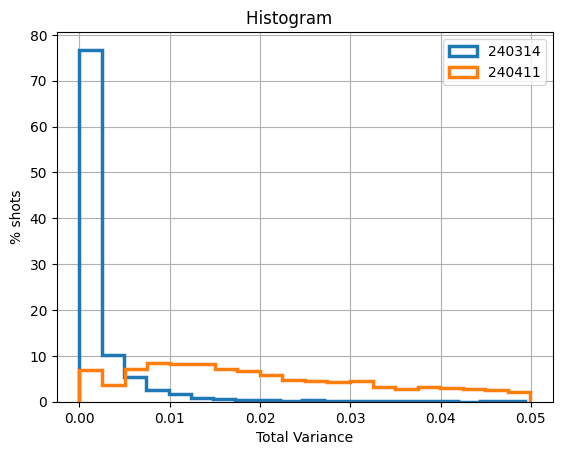

In [30]:
weights_time_240314 = 100*np.ones_like(df_time_var_clean_sum_240314) / len(df_time_var_clean_sum_240314)
weights_time_240411 = 100*np.ones_like(df_time_var_clean_sum_240411) / len(df_time_var_clean_sum_240411)

df_time_var_clean_sum_240314.hist(bins=20,weights=weights_time_240314,histtype="step",linewidth=2.5,label='240314')
df_time_var_clean_sum_240411.hist(bins=20,weights=weights_time_240411,histtype="step",linewidth=2.5,label='240411')

plt.ylabel('% shots')
plt.xlabel('Total Variance')
#plt.xscale('log')
plt.title('Histogram      ')#(total num. shots='+str(len(df_time_clean_var_sum_240314))+')')
plt.legend()

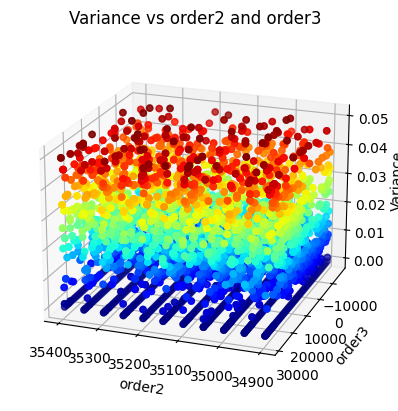

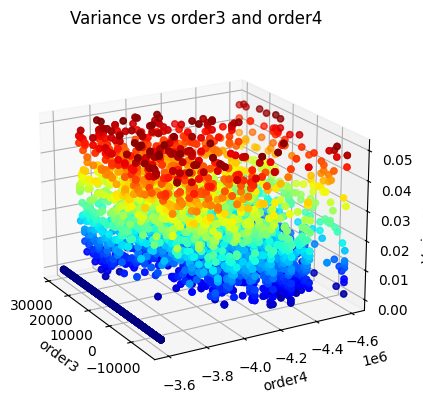

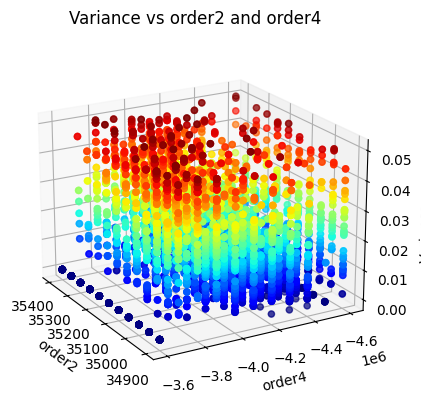

In [31]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_input_clean_240411['order2'], df_input_clean_240411['order3'], df_time_var_clean_sum_240411,c=df_time_var_clean_sum_240411,cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Variance')
ax.view_init(elev=20., azim=110)
plt.title('Variance vs order2 and order3')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_input_clean_240411['order3'], df_input_clean_240411['order4'], df_time_var_clean_sum_240411,c=df_time_var_clean_sum_240411,cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Variance')
ax2.view_init(elev=20., azim=150)
plt.title('Variance vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_input_clean_240411['order2'], df_input_clean_240411['order4'], df_time_var_clean_sum_240411,c=df_time_var_clean_sum_240411,cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Variance')
ax3.view_init(elev=20., azim=150)
plt.title('Variance vs order2 and order4')
plt.show()

## Train the model

In [32]:
def train_roundtrip(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)
    
    #train forward model with Random forest
    n_estimators = 300
    max_features = 'sqrt'
    max_depth=20
    random_state=18
    rf_model_forward=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state)
    y_predict_forest_forward=rf.make_rf_prediction(rf_model_forward,X_test)

    #train backward model with RF
    rf_model_backward=rf.fit_random_forest(y_train,X_train,n_estimators, max_features,max_depth, random_state)
    X_predict_forest_backward=rf.make_rf_prediction(rf_model_backward,y_test)

    #roundtrip prediction
    y_predict_backforw=rf_model_forward.predict(X_predict_forest_backward)
    
    #study the erro distribution
    df_error_backforw_forest=abs(y_test_reset-y_predict_backforw)
    df_error_backforw_forest=df_error_backforw_forest.sum(axis=1)/y_test.shape[1] #sum error / num columns
    #print(df_error_backforw_forest)

    #print(df_error_backforw_forest.idxmax())
    #print(df_error_backforw_forest.max())
    return df_error_backforw_forest,rf_model_forward,rf_model_backward

### TRain the model without dropping any point

In [33]:
#define input and output for the model
#240314
X_240314=df_input_240314[['order2','order3','order4']]
y_240314=df_time_240314
#split into train and test set
X_train_240314, X_test_240314, y_train_240314, y_test_240314 = train_test_split(
    X_240314, y_240314, test_size=0.3, random_state=101)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset_240314=y_test_240314.reset_index(drop=True)

#240411
X_240411=df_input_240411[['order2','order3','order4']]
y_240411=df_time_240411
#split into train and test set
X_train_240411, X_test_240411, y_train_240411, y_test_240411 = train_test_split(
    X_240411, y_240411, test_size=0.3, random_state=101)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset_240411=y_test_240411.reset_index(drop=True)

## TRain the model without the high variance
#240314
df_error_240314,model_forward_240314,model_backward_240314=train_roundtrip(
    X_train_240314, X_test_240314, y_train_240314, y_test_240314)
#240411
df_error_240411,model_forward_240411,model_backward_240411=train_roundtrip(
    X_train_240411, X_test_240411, y_train_240411, y_test_240411)



/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Train the model without the high var values

In [34]:
#define input and output for the model
#240314
X_clean_240314=df_input_clean_240314[['order2','order3','order4']]
y_clean_240314=df_time_clean_240314
#split into train and test set
X_train_clean_240314, X_test_clean_240314, y_train_clean_240314, y_test_clean_240314 = train_test_split(
    X_clean_240314, y_clean_240314, test_size=0.3, random_state=101)
#Reset the index on y_test to have the same indexes as y_predict
y_test_clean_reset_240314=y_test_clean_240314.reset_index(drop=True)
#240411
X_clean_240411=df_input_clean_240411[['order2','order3','order4']]
y_clean_240411=df_time_clean_240411
#split into train and test set
X_train_clean_240411, X_test_clean_240411, y_train_clean_240411, y_test_clean_240411 = train_test_split(
    X_clean_240411, y_clean_240411, test_size=0.3, random_state=101)
#Reset the index on y_test to have the same indexes as y_predict
y_test_clean_reset_240411=y_test_clean_240411.reset_index(drop=True)


## TRain the model without the high variance
#240314
df_error_clean_240314,model_forward_clean_240314,model_backward_clean_240314=train_roundtrip(
    X_train_clean_240314, X_test_clean_240314, y_train_clean_240314, y_test_clean_240314)
#240411
df_error_clean_240411,model_forward_clean_240411,model_backward_clean_240411=train_roundtrip(
    X_train_clean_240411, X_test_clean_240411, y_train_clean_240411, y_test_clean_240411)


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


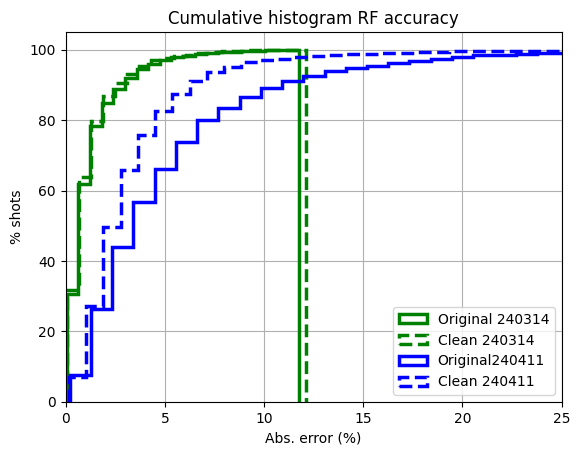

In [35]:
weights_240314 = 100*np.ones_like(df_error_240314) / len(df_error_240314)
weights_240411 = 100*np.ones_like(df_error_240411) / len(df_error_240411)
weights_clean_240314 = 100*np.ones_like(df_error_clean_240314) / len(df_error_clean_240314)
weights_clean_240411 = 100*np.ones_like(df_error_clean_240411) / len(df_error_clean_240411)

(100*df_error_240314).hist(bins=20,weights=weights_240314,cumulative=True,histtype="step",linewidth=2.5,color='g',label='Original 240314')
(100*df_error_clean_240314).hist(bins=20,weights=weights_clean_240314,cumulative=True,histtype="step",linewidth=2.5,color='g',linestyle='--',label='Clean 240314')
(100*df_error_240411).hist(bins=40,weights=weights_240411,cumulative=True,histtype="step",linewidth=2.5,color='b',label='Original240411')
(100*df_error_clean_240411).hist(bins=40,weights=weights_clean_240411,cumulative=True,histtype="step",linewidth=2.5,color='b',linestyle='--',label='Clean 240411')

plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,25)
plt.legend()
plt.show()

In [ ]:
plot_error_param_space(X_test_clean_240411,df_error_clean_240411)
plot_error_param_space(X_test_240411,df_error_240411)